In [1]:
# The term you are looking for to find the best choice of parameters when you have data values:
# supervised dimensionality reduction

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [3]:
import h5py

In [4]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)

import constants
imp.reload(constants)
from constants import *

# Get saved training-set waveforms

In [17]:
# trainset = ws.HDF5WaveformSet('../../data/TEOBv4_20hz/dh_train_corners_lhd.hdf5')
# amp_gp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_corners_lhd.hdf5'
# phase_gp_filename = '../../data/TEOBv4_20hz/gp_spline_phase_corners_lhd.hdf5'
#nodes_filename = '../../data/TEOBv4_20hz/nodes_corners_lhd.hdf5

# trainset = ws.HDF5WaveformSet('../../data/TEOBv4_20hz/dh_train_lhd_uncsamp.hdf5')
# amp_gp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_lhd_uncsamp.hdf5'
# phase_gp_filename = '../../data/TEOBv4_20hz/gp_spline_phase_lhd_uncsamp.hdf5'
# nodes_filename = '../../data/TEOBv4_20hz/nodes_lhd_uncsamp.hdf5'

trainset = ws.HDF5WaveformSet('../../data/TEOBv4_20hz/dh_train_lhd_uncsamp_rand.hdf5')
amp_gp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_lhd_uncsamp_rand.hdf5'
phase_gp_filename = '../../data/TEOBv4_20hz/gp_spline_phase_lhd_uncsamp_rand.hdf5'
nodes_filename = '../../data/TEOBv4_20hz/nodes_lhd_uncsamp_rand.hdf5'


# Manually specify locations of interpolating nodes
namp = 20
nphase = 19
h = trainset[0]
amp_mfs = np.logspace(np.log10(h.x[0]), np.log10(h.x[-1]), namp)
phase_mfs = np.logspace(np.log10(h.x[0]), np.log10(h.x[-1]), nphase+1)
phase_mfs = np.delete(phase_mfs, 0)

print trainset.parameters().shape
print len(amp_mfs), amp_mfs
print len(phase_mfs), phase_mfs

(1357, 5)
20 [ 0.00021     0.0002851   0.00038707  0.00052549  0.00071343  0.00096858
  0.00131498  0.00178526  0.00242373  0.00329054  0.00446735  0.00606503
  0.0082341   0.01117891  0.01517688  0.02060467  0.02797363  0.03797798
  0.05156024  0.07      ]
19 [ 0.0002851   0.00038707  0.00052549  0.00071343  0.00096858  0.00131498
  0.00178526  0.00242373  0.00329054  0.00446735  0.00606503  0.0082341
  0.01117891  0.01517688  0.02060467  0.02797363  0.03797798  0.05156024
  0.07      ]


In [18]:
f = h5py.File(nodes_filename)
f['amp_mfs'] = amp_mfs
f['phase_mfs'] = phase_mfs
f.close()

1357


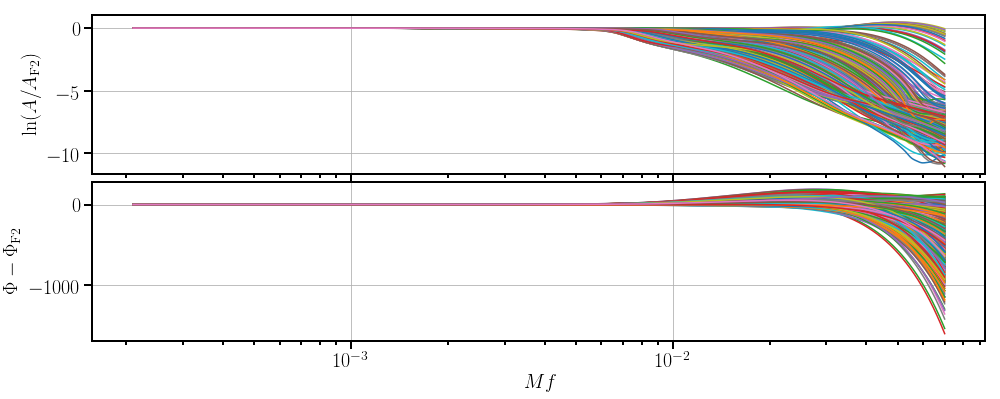

In [19]:
print len(trainset)

fig, (ax1, ax2) = wave.plot_waveforms_fd([trainset[i] for i in range(0, len(trainset), 1)])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate Gaussian processes

In [20]:
# Calculate the amplitude for all waveforms in the training set
# at the amplitude empirical nodes
damp_ts_list = []
for j in range(len(amp_mfs)):
    mf = amp_mfs[j]
    damp_ts = np.array([trainset[i].interpolate('amp')(mf) for i in range(len(trainset))])
    damp_ts_list.append(damp_ts)
    
# Calculate the phase for all waveforms in the training set
# at the phase empirical nodes
dphase_ts_list = []
for j in range(len(phase_mfs)):
    mf = phase_mfs[j]
    dphase_ts = np.array([trainset[i].interpolate('phase')(mf) for i in range(len(trainset))])
    dphase_ts_list.append(dphase_ts)
    
# Relevant parameters for the training set waveforms
params_ts = trainset.parameters()

In [21]:
limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
kernel_type = 'matern52'

damp_gp_list = []
for i in range(len(damp_ts_list)):
    print i
    points = params_ts
    data = damp_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits)
    damp_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    
    print gpr.get_hyperparameters(damp_gp)
    damp_gp_list.append(damp_gp)

0
[  6.23888482e-04   1.85564994e+00   3.07350276e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   1.39581655e-08]
1
[  7.65375951e-04   1.84190163e+00   3.08297803e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   1.84307311e-08]
2
[  9.78607442e-04   1.82717355e+00   3.09080126e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   2.59302854e-08]
3
[  1.27062658e-03   1.81373434e+00   3.09213819e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   3.66832879e-08]
4
[  1.61591830e-03   1.79073433e+00   3.10386429e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   5.21134870e-08]
5
[  2.08233675e-03   1.76862632e+00   3.09318463e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   7.47213152e-08]
6
[  2.70442962e-03   1.74782826e+00   3.07834264e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   1.08349956e-07]
7
[  3.55530118e-03   1.72716736e+00   3.05815473e+00   4.00000000e+00
   2.00000000e+04   2.00000000e+04   1.59785421e-07]
8
[  4.9

In [22]:
limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
kernel_type = 'matern52'

dphase_gp_list = []
for i in range(len(dphase_ts_list)):
    print i
    points = params_ts
    data = dphase_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits, length_scale_factor=[0.1, 10.0], 
                                                             sigma_n_factor=[1.0e-6, 0.1])
    #print hyper_limits
    dphase_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    
    print gpr.get_hyperparameters(dphase_gp)
    dphase_gp_list.append(dphase_gp)

0
[  2.15807278e-02   1.85994370e+00   2.85558741e+00   7.01373386e+00
   2.39723384e+04   4.49840746e+04   4.33536116e-05]
1
[  1.20880160e-01   1.73224236e+00   3.01772541e+00   7.15254600e+00
   2.21838542e+04   4.27797647e+04   1.10185892e-04]
2
[  3.46997849e-01   1.75780304e+00   3.13033255e+00   7.35079536e+00
   2.18440585e+04   4.43545326e+04   1.93377209e-04]
3
[  7.72523180e-01   1.80447409e+00   3.23430469e+00   7.56518266e+00
   2.18775266e+04   4.64263571e+04   2.94439090e-04]
4
[  1.50298695e+00   1.85235063e+00   3.33591644e+00   7.78540245e+00
   2.21922735e+04   4.84105638e+04   4.17030507e-04]
5
[  2.69140353e+00   1.89842578e+00   3.43325035e+00   8.00949793e+00
   2.27790359e+04   5.00000000e+04   5.68706384e-04]
6
[  4.56259760e+00   1.94333370e+00   3.53203767e+00   8.25273750e+00
   2.38515375e+04   5.00000000e+04   7.55775154e-04]
7


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.66803311e+00,  -3.69361803e-03,   2.87201267e-02,
        -3.57014734e-03,  -1.18648498e-02,  -1.90601686e+01,
         6.03162288e-04]), 'nit': 29, 'funcalls': 74}
  " state: %s" % convergence_dict)


[  7.46774883e+00   1.98545539e+00   3.63491144e+00   8.51204151e+00
   2.50920451e+04   5.00000000e+04   9.82614804e-04]
8


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.28982168e+00,   2.37560548e-02,   1.34844206e-04,
        -1.14351189e-02,  -2.05915159e-02,  -2.73366717e+01,
         1.94180592e-03]), 'nit': 44, 'funcalls': 103}
  " state: %s" % convergence_dict)
/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.05725959e+00,  -1.44111209e-03,  -1.82583628e-02,
        -5.68418954e-02,   5.80953178e-03,  -1.61360446e+01,
        -5.37346718e-04]), 'nit': 22, 'funcalls': 74}
  " state: %s" % convergence_dict)


[  1.19773906e+01   2.02662766e+00   3.75261195e+00   8.80699188e+00
   2.65834427e+04   5.00000000e+04   1.26460164e-03]
9
[  1.86925882e+01   2.04687160e+00   3.86424808e+00   9.10953400e+00
   2.80807264e+04   5.00000000e+04   1.62723874e-03]
10
[  2.50060642e+01   1.89549714e+00   3.80842623e+00   8.95853426e+00
   2.62823467e+04   5.00000000e+04   1.96713712e-03]
11
[  2.95082964e+01   1.45672599e+00   3.74623130e+00   8.74705323e+00
   2.05431268e+04   5.00000000e+04   1.33172700e-03]
12
[  4.67904882e+01   1.37226588e+00   4.09298471e+00   9.45228659e+00
   1.67697962e+04   5.00000000e+04   6.26606750e-05]
13


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.16389841e-02,   2.07064523e-02,  -2.79390053e-02,
        -1.40542005e+01,   1.69059551e-02,  -1.53770824e+02,
         8.15347150e-04]), 'nit': 33, 'funcalls': 78}
  " state: %s" % convergence_dict)


[  8.62340393e+01   1.43706295e+00   4.59166734e+00   1.00000000e+01
   1.41790755e+04   5.00000000e+04   1.13778858e-04]
14


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  4.17977571e-04,  -1.36772520e-04,  -1.69952447e-03,
        -6.01490516e+01,  -2.04077776e-04,  -5.56813742e+01,
        -6.07523369e-05]), 'nit': 19, 'funcalls': 72}
  " state: %s" % convergence_dict)
/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -3.62493843e-03,   2.29972973e-03,  -1.11215093e-02,
        -6.04301087e+01,   3.33390207e-03,  -5.57586943e+01,
        -1.47755974e-05]), 'nit': 31, 'funcalls': 84}
  " state: %s" % convergence_dict)
/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b te

[  1.59472770e+02   1.48064993e+00   4.93067623e+00   1.00000000e+01
   1.44374621e+04   5.00000000e+04   4.43841460e-03]
15


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -5.09859622e-03,   5.86164958e-03,   5.12003327e-03,
        -9.16380830e+01,   1.61505898e-03,   8.24531261e-03,
        -3.32267828e-04]), 'nit': 19, 'funcalls': 78}
  " state: %s" % convergence_dict)
/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.73671544e-03,  -6.71708974e-03,   3.42700127e-03,
        -9.71585758e+01,   5.74448617e-03,  -4.34458693e-03,
         8.53584175e-04]), 'nit': 36, 'funcalls': 88}
  " state: %s" % convergence_dict)


[  2.64899128e+02   1.56700598e+00   5.14373412e+00   1.00000000e+01
   1.41874326e+04   4.42485593e+04   2.88263354e-02]
16


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.22643709e-02,   1.85246469e-03,   6.60054540e-03,
        -8.35967706e+01,  -6.06571779e-02,  -2.53465508e-03,
        -1.83443993e-03]), 'nit': 15, 'funcalls': 61}
  " state: %s" % convergence_dict)


[  3.93079987e+02   1.63017863e+00   5.21616771e+00   1.00000000e+01
   1.24815722e+04   3.70950898e+04   7.35930373e-02]
17


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.00723431e-02,   7.00065252e-03,   1.34594271e-02,
        -1.08394485e+02,   2.80468800e-02,   1.48119434e-05,
        -1.05065691e-03]), 'nit': 22, 'funcalls': 65}
  " state: %s" % convergence_dict)


[  6.17477321e+02   1.69491276e+00   5.55728405e+00   1.00000000e+01
   1.09185931e+04   3.30932389e+04   2.00749397e-01]
18
[  1.00435458e+03   1.51577831e+00   6.00673855e+00   1.00000000e+01
   1.01768348e+04   3.02077360e+04   7.13890897e-01]


In [23]:
# Save GPR functions
gpr.save_gaussian_process_regression_list(amp_gp_filename, damp_gp_list, 'matern52')
gpr.save_gaussian_process_regression_list(phase_gp_filename, dphase_gp_list, 'matern52')

# Test GPSplineSurrogate class

In [24]:
trainset = ws.HDF5WaveformSet('../../data/TEOBv4_20hz/h_train_corners_lhd.hdf5')
dtrainset = ws.HDF5WaveformSet('../../data/TEOBv4_20hz/dh_train_corners_lhd.hdf5')

#testset_rand = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/h_test2.hdf5')
#dtestset_rand = ws.HDF5WaveformSet('../../data/TEOBv4_40hz/dh_test2.hdf5')

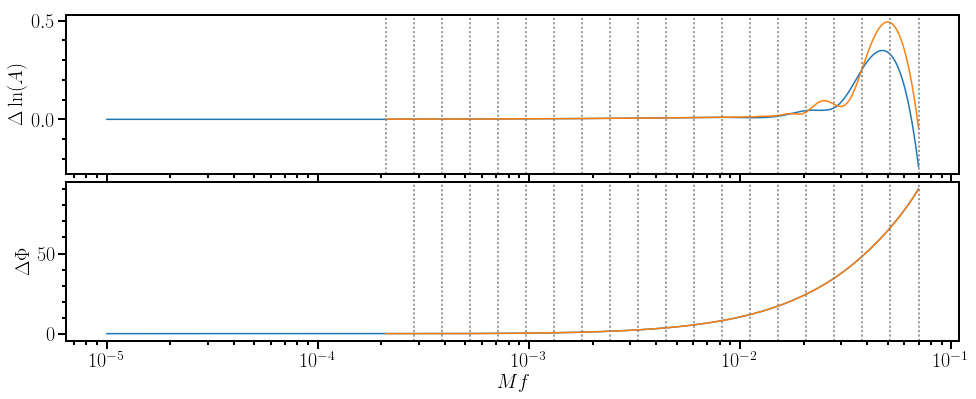

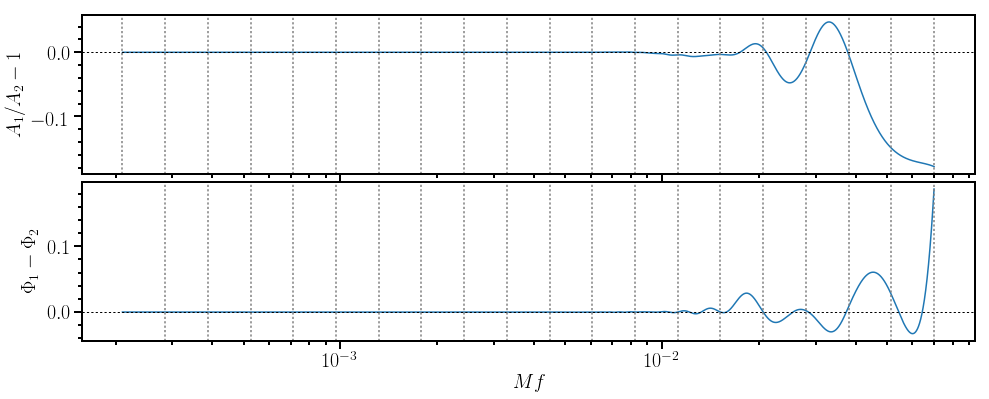

In [25]:
# nodes_filename = '../../data/TEOBv4_20hz/nodes_corners_lhd.hdf5'
# gp_amp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_corners_lhd.hdf5'
# gp_phase_filename = '../../data/TEOBv4_20hz/gp_spline_phase_corners_lhd.hdf5'
# sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=3, npoints=10000)

# nodes_filename = '../../data/TEOBv4_20hz/nodes_lhd_uncsamp.hdf5'
# gp_amp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_lhd_uncsamp.hdf5'
# gp_phase_filename = '../../data/TEOBv4_20hz/gp_spline_phase_lhd_uncsamp.hdf5'
# sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=3, npoints=10000)

nodes_filename = '../../data/TEOBv4_20hz/nodes_lhd_uncsamp_rand.hdf5'
gp_amp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_lhd_uncsamp_rand.hdf5'
gp_phase_filename = '../../data/TEOBv4_20hz/gp_spline_phase_lhd_uncsamp_rand.hdf5'
sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=3, npoints=10000)

i = 28
htest = trainset[i]
dhtest = dtrainset[i]
params = dtrainset.get_waveform(i, data='parameters')

# i = 0
# dhtest = dtestset_rand[i]
# params = dtestset_rand.get_waveform(i, data='parameters')

hsur = sur.geometric_waveform(params)
hf2 = sur.geometric_reference_waveform(params)
dhsur = sur.amp_phase_difference(params)

# Resample
hsur.resample(htest.x)
hsur.phase -= hsur.phase[0]

fig, (ax1, ax2) = wave.plot_waveforms_fd([dhsur, dhtest])
for mf in sur.mf_amp:
    ax1.axvline(mf, c='gray', ls=':')
for mf in sur.mf_phase:
    ax2.axvline(mf, c='gray', ls=':')
#ax1.set_ylim(-0.01, 0.01)
# ax2.set_ylim(-1, 0.1)
ax1.minorticks_on()
ax2.minorticks_on()
ax1.set_ylabel(r'$\Delta\ln(A)$')
ax2.set_ylabel(r'$\Delta\Phi$')
ax2.set_xlabel(r'$Mf$')

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(hsur, htest)
for mf in sur.mf_amp:
    ax1.axvline(mf, c='gray', ls=':')
for mf in sur.mf_phase:
    ax2.axvline(mf, c='gray', ls=':')
# ax1.set_ylim(-0.05, 0.05)
# ax2.set_ylim(-0.1, 0.1)
ax1.minorticks_on()
ax2.minorticks_on()
# ax1.set_ylabel(r'$\Delta\ln(A)_{\rm Sur}/\Delta\ln(A)_{\rm Test} - 1$')
# ax2.set_ylabel(r'$\Delta\Phi_{\rm Sur}-\Delta\Phi_{\rm Test}$')
ax2.set_xlabel(r'$Mf$')

(<matplotlib.figure.Figure at 0x1296d54d0>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1255b0b10>,
  <matplotlib.axes._subplots.AxesSubplot at 0x12588d750>))

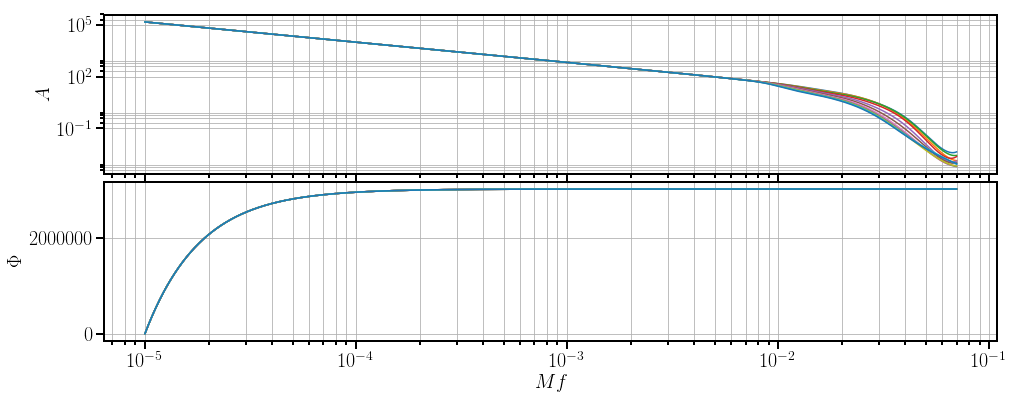

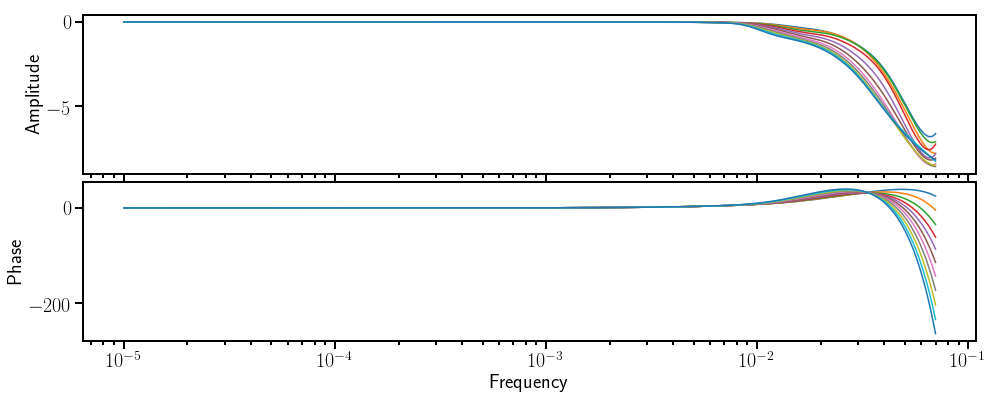

In [26]:
# Vary 1 parameter

q = 1.0
s1 = 0.3
s2 = 0.1
lambda1 = 1000.
lambda2 = 1000.
ps = np.array([[q, s1, s2, lambda1, lambda2] for lambda1 in np.linspace(0, 5000., 11)])

hs = [sur.geometric_waveform(p) for p in ps]
dhs = [sur.amp_phase_difference(p) for p in ps]

fig, (ax1, ax2) = wave.plot_waveforms_fd(hs)
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid(which='both')
ax2.grid(which='both')

wave.plot_waveforms_fd(dhs)